In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, auc
import scipy.stats as scistats

# ROC/PR curves from noisy measurements
And their AUC

## Assumptions
True (population) distribution of x:
$$
x\sim \mathcal{N}(\mu, \sigma_{pop})
$$
The measurement adds noise: 
$$
x_{meas} \sim \mathcal{N}(x, \sigma_{meas})
$$

We try to predict $x_{meas} < \text{cut}$ given a prediction for $x_{meas}$.

Let's say we have a perfect prediction, that would be the true $x$. What is the then the best ROC/PR curve we can get (given that the measurement is noisy)?

### Compare with MC

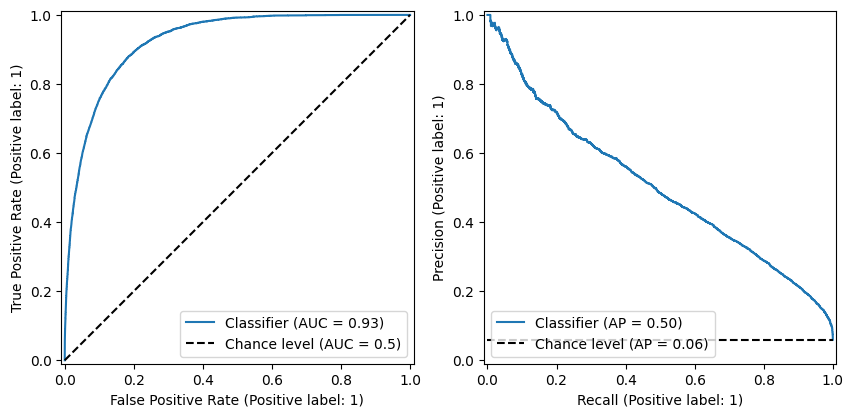

In [10]:
mu = 9.4
sig_pop = 0.5
sig_meas = 0.4
sig_tot = (sig_pop**2 + sig_meas**2) ** 0.5

# Do simple MC
n = 100000
x = np.random.normal(mu, sig_pop, n)
xmeas = np.random.normal(x, sig_meas)
cut = 8.4
y_test = xmeas < cut
rho = sig_pop / sig_tot
# f, ax = plt.subplots(1)
# bins = np.arange(6, 12, 0.1)
# ax.hist(xmeas, bins=bins, color='b', alpha=0.8)
# ax.hist(x, bins=bins, color='r', alpha=0.5)
# # ax.hist(x[x < cut], bins=bins, color='r', alpha=0.5, hatch='//')
# ax.hist(xmeas[xmeas < cut], bins=bins, color='b', alpha=0.5, hatch='xx')
y_prob = scistats.norm.cdf(cut, x, sig_meas)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax1, plot_chance_level=True)
PrecisionRecallDisplay.from_predictions(y_test, y_prob, ax=ax2, plot_chance_level=True)

## False/True positives/negatives
They simply come from a 2d gaussian distribution with:
$$
\rho = \sigma_{pop}/\sqrt{\sigma_{meas}^2 + \sigma_{pop}^2}
$$
as can be seen in the plot below. 

The false/true positive/negatives can be calculated by numerically integrating the 2d distr (no analytical solutions).

prob for getting a measurement below 8.4 given the cutoff 8.4 = 0.50
tp = 0.015
fn = 0.045
fp = 0.007
tn = 0.933


Text(0, 0.5, 'xmeas')

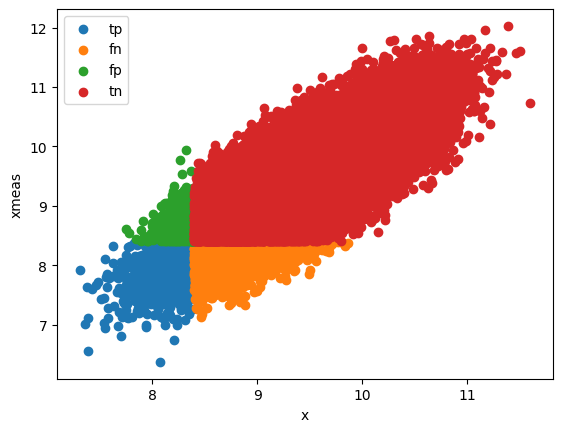

In [11]:
cut_try = 8.4
prob = scistats.norm.cdf(cut, cut_try, sig_meas)
print(
    f"prob for getting a measurement below {cut} given the cutoff {cut_try} = {prob:.2f}"
)
plt.scatter(x[y_test & (y_prob > prob)], xmeas[y_test & (y_prob > prob)], label="tp")
plt.scatter(x[y_test & (y_prob <= prob)], xmeas[y_test & (y_prob <= prob)], label="fn")
plt.scatter(x[~y_test & (y_prob > prob)], xmeas[~y_test & (y_prob > prob)], label="fp")
plt.scatter(
    x[~y_test & (y_prob <= prob)], xmeas[~y_test & (y_prob <= prob)], label="tn"
)
plt.legend()
print(f"tp = {np.sum(y_test & (y_prob > prob)) / n:.3f}")
print(f"fn = {np.sum(y_test & (y_prob <= prob)) / n:.3f}")
print(f"fp = {np.sum(~y_test & (y_prob > prob)) / n:.3f}")
print(f"tn = {np.sum(~y_test & (y_prob <= prob)) / n:.3f}")
plt.xlabel("x")
plt.ylabel("xmeas")

### From integrating multivariate normal distr

In [12]:
@np.vectorize
def compute_tp_fn_fp_tn(cut_try, mu, sig_pop, sig_meas, cut):
    """
    Calculate true/false positives/negatives from 2d gaussian distribution
    """
    sig_tot = (sig_pop**2 + sig_meas**2) ** 0.5
    rv = scistats.multivariate_normal(
        [mu, mu], [[sig_pop**2, sig_pop**2], [sig_pop**2, sig_tot**2]]
    )

    #These make up the probabilities 
    #see also https://stats.stackexchange.com/questions/490519/formula-for-expected-false-positive-negative-rates-in-hiring-decisions-based-o
    G = scistats.norm.cdf(cut_try, mu, sig_pop)
    G2 = scistats.norm.cdf(cut, mu, sig_tot)
    F = rv.cdf([cut_try, cut])
    tp = F
    fp = G - F
    fn = G2 - F
    tn = 1 - tp - fn - fp
    #prob given the cutoff try
    prob = scistats.norm.cdf(cut, cut_try, sig_meas)
    return tp, fn, fp, tn, prob


tp, fn, fp, tn, prob = compute_tp_fn_fp_tn(cut_try, mu, sig_pop, sig_meas, cut_try)
# Compare these to calculate by MC
print(f"prob = {prob:.3f}")
print(f"tp = {tp:.3f}")
print(f"fn = {fn:.3f}")
print(f"fp = {fp:.3f}")
print(f"tn = {tn:.3f}")

prob = 0.500
tp = 0.015
fn = 0.044
fp = 0.008
tn = 0.933


## ROC/PR curve from 2d mv normal dist
By integrating as above

In [13]:
def compute_fpr_tpr_ppv(cuts, mu, sig_pop, sig_meas, cut):
    """
    Compute false/true postive ratio and positive predictive value
    i.e. sensitivity, recall and precision
    """
    tp, fn, fp, tn, prob = compute_tp_fn_fp_tn(cuts, mu, sig_pop, sig_meas, cut)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    tpr = 1 - fnr  # recall
    ppv = tp / (tp + fp)  # precision
    return fpr, tpr, ppv


def compute_roc_pr_curve(mu, sig_pop, sig_meas, cut, axs=None, label=None, **kwargs):
    """
    Compute ROC and PR curve for given mu, sig_pop, sig_meas and cut, by looping over
    possible cut_trys
    """
    sig_tot = (sig_pop**2 + sig_meas**2) ** 0.5
    cuts = np.arange(mu - 5 * sig_tot, mu + 5 * sig_tot, 0.05)
    fpr, tpr, ppv = compute_fpr_tpr_ppv(cuts, mu, sig_pop, sig_meas, cut)
    if axs is None:
        f, axs = plt.subplots(1, 2, figsize=(10, 5))
    isort = np.argsort(fpr)
    fpr = fpr[isort]
    tpr = tpr[isort]
    roc_auc = auc(fpr, tpr)
    label_ = f"auc ROC = {roc_auc:.2f}"
    if label is not None:
        label_ = label + "\n" + label_
    axs[0].plot(fpr, tpr, label=label_, **kwargs)
    isort = np.argsort(tpr)
    tpr = tpr[isort]
    ppv = ppv[isort]
    auc_pr = auc(tpr, ppv)
    label_ = f"auc PR = {auc_pr:.2f}"
    if label is not None:
        label_ = label + "\n" + label_
    axs[1].plot(tpr, ppv, label=label_, **kwargs)
    axs[0].legend()
    axs[1].legend()
    axs[0].set(xlabel="fpr", ylabel="tpr")
    axs[1].set(xlabel="recall", ylabel="precision")

### ROC/PR curves given $\sigma_{pop/meas}$

8.5 0.7808688094430303 1.0932163332202427
9.4 0.7808688094430303 1.5617376188860606


Text(0.5, 1.0, 'male PR')

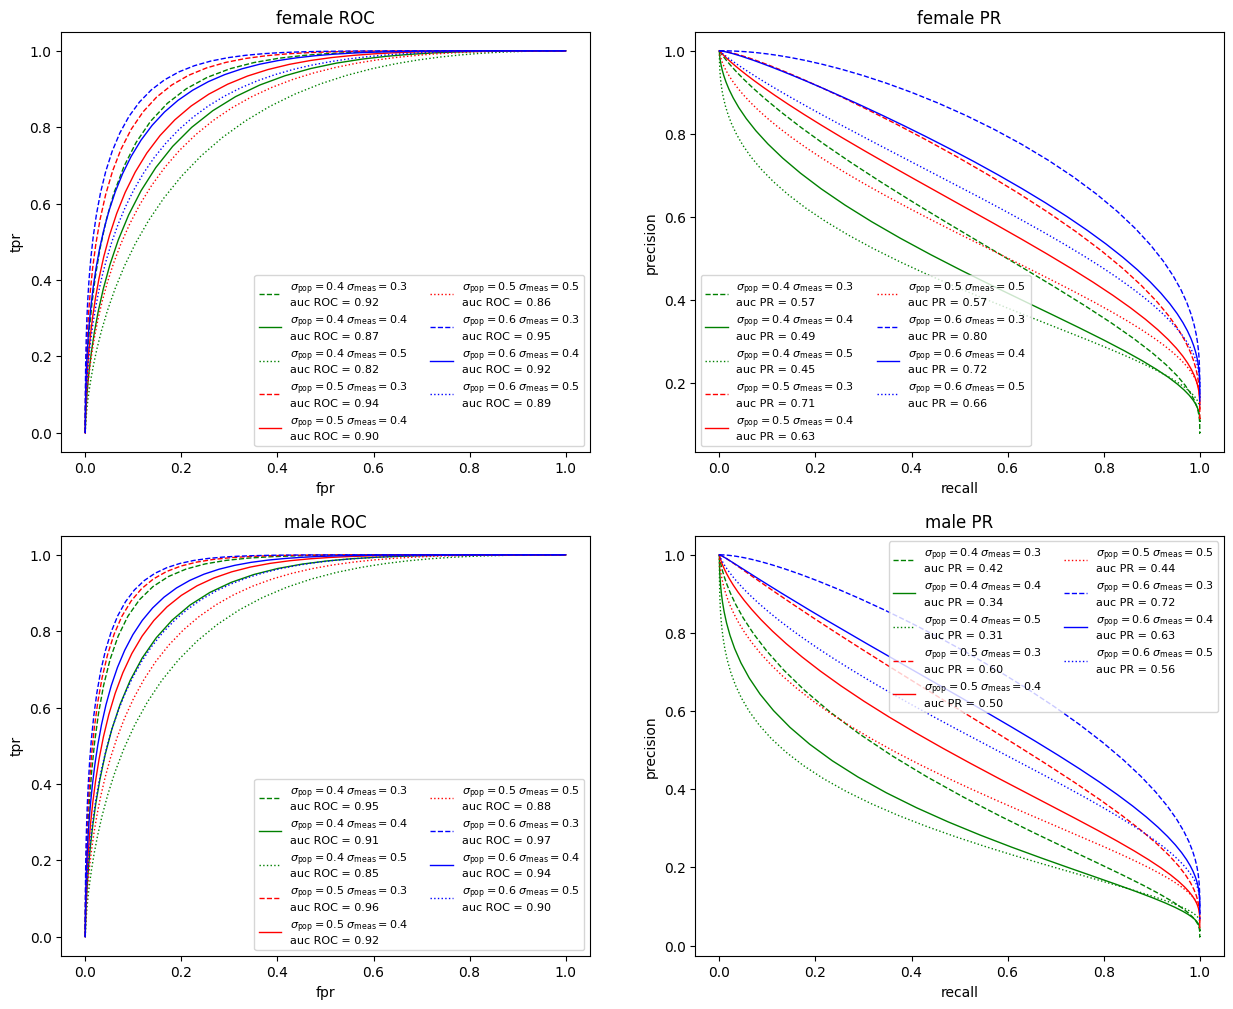

In [14]:
f, axs = plt.subplots(2, 2, figsize=(15, 12))
for mu, axsi, cut in zip([8.5, 9.4], axs, [7.8, 8.4]):
    for sig_pop, color in zip([0.4, 0.5, 0.6], ["g", "r", "b"]):
        for sig_meas, ls in zip([0.3, 0.4, 0.5], ["--", "-", ":"]):
            sig_tot = (sig_pop**2 + sig_meas**2) ** 0.5
            rho = sig_pop / sig_tot
            ns = (mu - cut) / sig_tot
            if sig_pop == 0.5 and sig_meas == 0.4:
                print(mu, rho, ns)
            lw = 1
            compute_roc_pr_curve(
                mu,
                sig_pop,
                sig_meas,
                cut,
                axs=axsi,
                color=color,
                ls=ls,
                lw=lw,
                label=f"$\\sigma_{{\\rm pop}} = {sig_pop:.1f}$ $\\sigma_{{\\rm meas}} = {sig_meas:.1f}$",
            )
for ax in axs.flatten():
    ax.legend(ncol=2, fontsize=8)
    
axs[0, 0].set_title('female ROC')
axs[0, 1].set_title('female PR')
axs[1, 0].set_title('male ROC')
axs[1, 1].set_title('male PR')


### ROC/PR curves are completely determined by $\rho$ and $n\sigma_{tot}$
The distance to the cutoff and the width of the distribution determines the ROC/PR curves. 

If $\rho = \sigma_{pop}/\sqrt{\sigma_{meas}^2 + \sigma_{pop}^2}$ = 1 the measurement is perfect and the ROC/PR curves are, but if $rho=0$ the measurement is useless. If the cutoff is farther away from the mean the ROC curve will be better, because there will be very few false positive/negatives, but the PR curve will be worse, because the precision drops.


Text(0.5, 1.0, 'PR')

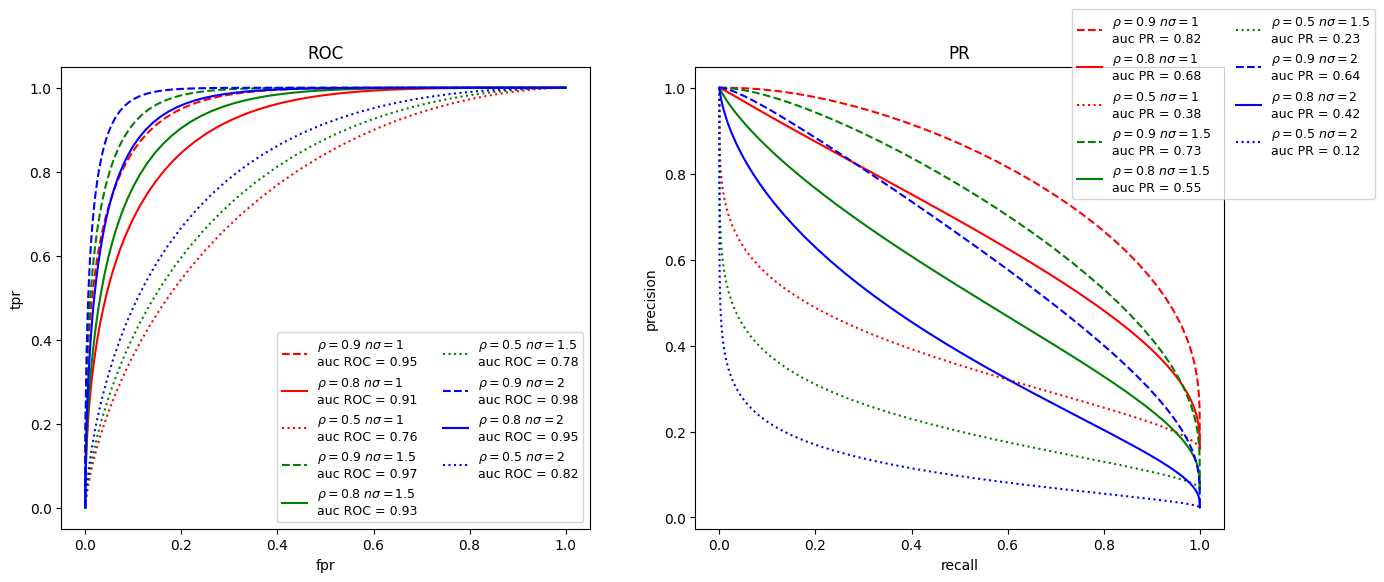

In [15]:
mu = 0
sig_tot = 1
f, axs = plt.subplots(1, 2, figsize=(15, 6))

for n, color in zip([1, 1.5, 2], ["r", "g", "b", "c", "m", "k"]):
    for rho, ls in zip([0.9, 0.8, 0.5], ["--", "-", ":", "-."]):
        # sig_meas = rho
        # sig_meas = sig_tot * fmeas**0.5
        # sig_pop = (sig_tot**2 - sig_meas**2)**0.5
        sig_pop = rho
        sig_meas = (sig_tot**2 - sig_pop**2) ** 0.5
        compute_roc_pr_curve(
            0,
            sig_pop,
            sig_meas,
            -n,
            axs=axs,
            label=f"$\\rho = {rho}$ $n\\sigma = {n}$",
            color=color,
            ls=ls,
        )


axs[0].legend(ncol=2, fontsize=9, loc=4)
axs[1].legend(ncol=2, fontsize=9, bbox_to_anchor=(0.7, 0.7))
axs[0].set_title('ROC')
axs[1].set_title('PR')